<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-02-04-regularized-glm-poisson-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4. Regularized Poisson Regression Model

Regularized Poisson regression is a statistical modeling technique used to predict count data while addressing overfitting through regularization. Count data often follows a Poisson distribution, but standard Poisson regression can need help with high-dimensional data or highly correlated predictors, leading to unstable estimates. Techniques like **ridge**, **lasso**, and **elastic net** add penalty terms to improve interpretability and accuracy. This tutorial introduces how to implement regularized Poisson regression in R.  We will first fit the model from scratch to understand the theory and then use the {glmnet} package to apply ridge, lasso, and elastic net Poisson regression. This approach provides theoretical insights and practical skills for applying regularized Poisson regression in various contexts, from academic research to industry applications.

## Overview

The **Regularized Poisson Regression Model** is a variant of Poisson regression used to model count data, where the goal is to estimate the relationship between a set of predictors and a count outcome (e.g., number of events). The regularization and the offset are additional components that refine the model and improve its performance, especially when dealing with complex or noisy data.

The componets Regularized Poisson Regression Model with offset:

1. **Poisson Regression**:

   - Poisson regression is a type of generalized linear model (GLM) where the outcome variable follows a Poisson distribution. It's commonly used for modeling count data (e.g., the number of occurrences of an event).
   - The Poisson distribution has the probability mass function:

  $$  P(Y = y) = \frac{\lambda^y e^{-\lambda}}{y!}, \quad y = 0, 1, 2, \dots $$
   
     where $\lambda$ is the expected count (rate parameter), and $Y$ is the random variable representing the count.

   - The Poisson regression model assumes that:
     
     $$ \log(\lambda) = \mathbf{X} \beta $$
     
     where $\lambda$ is the expected count, $\mathbf{X}$ is the matrix of predictor variables, and $\beta$ is the vector of coefficients to be estimated.

2. **Offset**:

The offset allows you to adjust for known exposure levels (such as time, area, or population size) that affect the count outcome but are not part of the predictors you want to estimate.

   - An **offset** is a known component in the model that is included in the linear predictor, but its coefficient is fixed (usually set to 1). This is often used when the scale of the response variable is affected by some external factor.
   - In a Poisson regression with an offset, the model becomes:
     
     $$ \log(\lambda) = \mathbf{X} \beta + \text{offset} $$
     
     where the offset can be any known value or variable that is not estimated during the regression but is important for predicting the count outcome (e.g., the total time at risk, population size, or exposure rate).

3. **Regularization**:

Regularization helps avoid overfitting, especially in cases where there are many predictors or the model is complex, leading to more stable and interpretable coefficients.

   - **Regularization** refers to adding a penalty term to the loss function in order to prevent overfitting and improve the generalization of the model. For Poisson regression, regularization is typically done using either **L1** (Lasso) or **L2** (Ridge) regularization:

     - **L1 regularization** encourages sparsity in the model by penalizing the absolute values of the coefficients.

     - **L2 regularization** penalizes the squared values of the coefficients, shrinking them toward zero but generally not leading to exact zeros.
   
   The regularized Poisson regression model with an offset can be written as:
   
   $$  \min_{\beta} \left( \sum_{i=1}^n \left( y_i \log(\lambda_i) - \lambda_i \right) + \text{Penalty}(\beta) \right) $$
   
   where $y_i$ is the observed count for the $i$-th observation, and $\lambda_i$ is the expected count, which depends on the predictors and the offset. The penalty term could represent either L1 or L2 regularization.




## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314966 sha256=df6d9c77197cf20d390ee394c450504c682e90c4882d0f5a32a5f1aa9f991d07
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regularized Poisson Model from Scratch

Let's go through the process of fitting a Poisson model with an offset and four predictors manually in R. Here’s the breakdown:

### Create a Data

For this example, we’ll simulate some count data, including four predictors and an offset variable.


In [ ]:
%%R
# Simulate Data
set.seed(123)
n <- 200  # Number of observations
p <- 5    # Number of predictors

# Simulate predictors
X <- matrix(rnorm(n * p), nrow = n, ncol = p)
colnames(X) <- paste0("X", 1:p)

# True coefficients
beta <- c(0.5, -0.3, 0, 0.8, 0)

# Simulate offset and Poisson outcome
offset <- log(runif(n, 1, 10))  # Offset variable
lambda <- exp(X %*% beta + offset)  # Poisson mean
Y <- rpois(n, lambda)  # Poisson-distributed response

# Combine data into a single dataframe
data <- data.frame(Y, offset, X)
head(data)


   Y    offset          X1         X2          X3          X4         X5
1  4 0.8907948 -0.56047565  2.1988103 -0.07355602  1.07401226  0.3562833
2  2 0.8331885 -0.23017749  1.3124130 -1.16865142 -0.02734697 -0.6580102
3  7 0.8512715  1.55870831 -0.2651451 -0.63474826 -0.03333034  0.8552022
4  0 1.7280932  0.07050839  0.5431941 -0.02884155 -1.51606762  1.1529362
5  9 1.6929415  0.12928774 -0.4143399  0.67069597  0.79038534  0.2762746
6 17 1.8790199  1.71506499 -0.4762469 -1.65054654 -0.21073418  0.1441047


### Regularized Poisson Regression Function

In [ ]:
%%R
# Regularized Poisson Regression Function
regularized_poisson <- function(X, Y, offset, alpha, lambda, max_iter = 1000, tol = 1e-6) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- rep(0, p)  # Initialize coefficients
  for (iter in 1:max_iter) {
    # Linear predictor
    eta <- X %*% beta + offset
    mu <- exp(eta)  # Predicted Poisson mean

    # Gradient of the log-likelihood
    grad <- t(X) %*% (Y - mu) / n

    # Add regularization gradient
    grad <- grad - lambda * (alpha * sign(beta) + 2 * (1 - alpha) * beta)

    # Update coefficients
    beta_new <- beta + 0.01 * grad  # Learning rate = 0.01

    # Check for convergence
    if (sum(abs(beta_new - beta)) < tol) {
      break
    }
    beta <- beta_new
  }
  return(beta)
}

### Cross-Validation Function

In [ ]:
%%R
# Cross-Validation Function
cross_validate <- function(X, Y, offset, alpha_values, lambda_values, folds = 5) {
  n <- nrow(X)
  fold_indices <- sample(rep(1:folds, length.out = n))

  results <- expand.grid(alpha = alpha_values, lambda = lambda_values, RMSE = NA)

  for (i in 1:nrow(results)) {
    alpha <- results$alpha[i]
    lambda <- results$lambda[i]

    rmse_fold <- numeric(folds)

    for (fold in 1:folds) {
      train_idx <- which(fold_indices != fold)
      test_idx <- which(fold_indices == fold)

      X_train <- X[train_idx, ]
      Y_train <- Y[train_idx]
      offset_train <- offset[train_idx]

      X_test <- X[test_idx, ]
      Y_test <- Y[test_idx]
      offset_test <- offset[test_idx]

      # Fit model
      beta <- regularized_poisson(X_train, Y_train, offset_train, alpha, lambda)

      # Predict on test set
      eta_test <- X_test %*% beta + offset_test
      mu_test <- exp(eta_test)

      # Calculate RMSE
      rmse_fold[fold] <- sqrt(mean((Y_test - mu_test)^2))
    }

    results$RMSE[i] <- mean(rmse_fold)
  }

  return(results)
}

## Cross-Validation for best parameters

In [ ]:
%%R
# Define alpha and lambda values
alpha_values <- c(0, 0.5, 1)  # Ridge (0), Elastic Net (0.5), Lasso (1)
lambda_values <- seq(0.01, 1, length.out = 10)

# Cross-validate to find the best parameters
cv_results <- cross_validate(X, Y, offset, alpha_values, lambda_values)

# Best parameters for each model
ridge_params <- cv_results[cv_results$alpha == 0, ][which.min(cv_results$RMSE), ]
lasso_params <- cv_results[cv_results$alpha == 1, ][which.min(cv_results$RMSE), ]
elastic_net_params <- cv_results[cv_results$alpha == 0.5, ][which.min(cv_results$RMSE), ]

### Fit ridge, lasso, and elastic net models


In [ ]:
%%R
# Fit final models
ridge_model <- regularized_poisson(X, Y, offset, ridge_params$alpha, ridge_params$lambda)
lasso_model <- regularized_poisson(X, Y, offset, lasso_params$alpha, lasso_params$lambda)
elastic_net_model <- regularized_poisson(X, Y, offset, elastic_net_params$alpha, elastic_net_params$lambda)

### Evaluate Model Performance

In [ ]:
%%
# Evaluate Model Performance
evaluate_model <- function(beta, X, Y, offset) {
  eta <- X %*% beta + offset
  mu <- exp(eta)
  RMSE <- sqrt(mean((Y - mu)^2))
  MAE <- mean(abs(Y - mu))
  return(list(RMSE = RMSE, MAE = MAE))
}

ridge_perf <- evaluate_model(ridge_model, X, Y, offset)
lasso_perf <- evaluate_model(lasso_model, X, Y, offset)
elastic_net_perf <- evaluate_model(elastic_net_model, X, Y, offset)

# Print Results
cat("Performance Metrics:\n")
print(list(
  Ridge = ridge_perf,
  Lasso = lasso_perf,
  ElasticNet = elastic_net_perf
))


UsageError: Cell magic `%%` not found.


## Regularized Poisson Model in R

 We will use the `glmnet()` function from the {glmnet} package to fit a regularized Poisson regression model with an offset and four predictors. The regularization helps prevent overfitting and improves the model's generalization performance.


### Install Required R Packages

In [3]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'rstatix',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'glmnet',
		 'ggpmisc'

	  	)

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [5]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



tidyverse      plyr   rstatix ggeffects patchwork   Metrics    glmnet   ggpmisc 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages


In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:ggpmisc"   "package:ggpp"      "package:glmnet"   
 [4] "package:Matrix"    "package:Metrics"   "package:patchwork"
 [7] "package:ggeffects" "package:rstatix"   "package:plyr"     
[10] "package:lubridate" "package:forcats"   "package:stringr"  
[13] "package:dplyr"     "package:purrr"     "package:readr"    
[16] "package:tidyr"     "package:tibble"    "package:ggplot2"  
[19] "package:tidyverse" "package:tools"     "package:stats"    
[22] "package:graphics"  "package:grDevices" "package:utils"    
[25] "package:datasets"  "package:methods"   "package:base"     


### Data

The County-level age-adjusted number and rate of diabetes patients, prevalence of obesity, physical inactivity and [Food environment index](https://www.ers.usda.gov/data-products/food-environment-atlas.aspx) for the year 2016-2020 were obtained from United States [Diabetes Surveillance System (USDSS)](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html).

![alt text](http://drive.google.com/uc?export=view&id=1pNL0FF71fPQqfSffEMjHuIdGdiZdYVDs)

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fi/ynrinqzj58f3x5mvc96as/county_data_2016_2020.csv?rlkey=zpy7qxrh6r4l01ct4hjxgcnds&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.



Dataset contains five years average (2016-2020) of following variables :

1.  `Diabetes_count` -  Diabetes number per county ([Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

2.  `Diabetes_per` - Diabetes number per county [(Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

3. `Urban_Rural` - Urban Rural County (USDA)

4. `PPO_total` - Total population per  county (US Census)

5. `Obesity` - % obesity per county [(Behavioral Risk Factor Surveillance System)](https://www.cdc.gov/brfss/)  

6. `Physical_Inactivity`: % adult access to exercise opportunities ([County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation))

7. `SVI` - Level of social vulnerability in the county relative to other counties in the nation or within the state.ocial vulnerability refers to the potential negative effects on communities caused by external stresses on human health. The CDC/ATSDR Social vulnerability Index (SVI) ranks all US counties on 15 social factors, including poverty, lack of vehicle access, and crowded housing, and groups them into four related themes. ( [CDC/ATSDR Social Vulnerability Index (SVI)](https://www.atsdr.cdc.gov/placeandhealth/svi/interactive_map.html))

8. `Food_Env_Index`: Measure of access to healthy food. The Food Environment Index ranges from a scale of 0 (worst) to 10 (best) and equally weights two indicators: 1) Limited access to healthy foods based on distance an individual lives from a grocery store or supermarket, locations for healthy food purchases in most communities; and 2) Food insecurity defined as the inability to access healthy food because of cost barriers.[County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation)

We will use `read_csv()` function of {readr} package to import data as a `tidy` data.


In [ ]:
%%R
# load data
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/county_data_2016_2020.csv")
# select variables
df<-mf |>
  dplyr::select(Diabetes_per,
                POP_Total,
                Obesity,
                Physical_Inactivity,
                Access_Excercise,
                Food_Env_Index,
                SVI,
                Urban_Rural
                ) |>
  glimpse()
# data processing
df$Diabetes_per<-as.integer(df$Diabetes_per)
df$Urban_Rural<-as.factor(df$Urban_Rural)

Rows: 3107 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): State, County, Urban_Rural
dbl (12): FIPS, X, Y, POP_Total, Diabetes_count, Diabetes_per, Obesity, Acce...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3,107
Columns: 8
$ Diabetes_per        <dbl> 9.24, 8.48, 11.72, 10.08, 10.26, 9.06, 11.80, 13.2…
$ POP_Total           <dbl> 55707.0, 218346.8, 25078.2, 22448.2, 57852.4, 1017…
$ Obesity             <dbl> 29.22, 28.94, 29.34, 29.44, 30.10, 19.86, 30.38, 3…
$ Physical_Inactivity <dbl> 26.42, 22.86, 23.72, 25.38, 24.76, 18.58, 28.66, 2…
$ Access_Excercise    <dbl> 70.8, 72.2, 49.8, 30.6, 24.6, 19.6, 48.0, 51.4, 62…
$ Food_Env_Index      <dbl> 6.9, 7.7, 5.5, 7.6, 8.1, 4.3, 6.5, 6.3, 6.4, 7.7, …
$ SVI                 <dbl> 0.5130, 0.3103, 0.9927, 0.8078, 0.5137, 0.8310, 0.…
$ Urban_Rural         <chr

#### Split Data

We will use the `ddply()` function of the {plyr}  package to split soil carbon datainto homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.

In [ ]:
%%R
seeds = 11076
tr_prop = 0.70

df$log_POP_Total<-log(df$POP_Total)
# training data (70% data)
train= ddply(df,.(Urban_Rural),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(Urban_Rural),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

#### Create x and y

You need to create two objects:

-   `y` for storing the outcome variable
-   `x` for holding the predictor variables. This should be created using the function model.matrix() allowing to automatically transform any qualitative variables (if any) into dummy variables, which is important because `glmnet()` can only take numerical, quantitative inputs. After creating the model matrix, we remove the intercept component at index = 1.

In [ ]:
%%R
df.train<-train[,-8]
# Predictor variables
x.train <- model.matrix(Diabetes_per ~., df.train)[,-1]
# Outcome variable
y.train <-df.train$Diabetes_per
# offset
m_offset <- df.train$log_POP_Total

### Ridge Regression

#### Cross-validation for the best lambda

Now we can apply `cv.glmnet()` function for cross-validation to choose the best lambda (regularization parameter). For example, suppose we designate $α$=0 for ridge regression and specify `nlambda` as 200. This implies that the model fit will be calculated solely for 200 $λ$ values.

We specify `family = poisson"` to indicate that we want to fit a Poisson regression model. Here we model the diabetes rate per county, The `offset` variable, here is log population per county need to be defined in model. This offset variable adjusts for the differing number of diabetes patients in different population levels per county.

In [ ]:
%%R
# cross validation
ridge.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="deviance",
                       nfold = 5,
                       alpha=0,
                       offset = m_offset,
                       family = "poisson",
                       nlambda=200,  standardize = TRUE)

Printing the resulting object gives some basic information on the cross-validation performed:

In [ ]:
%%R
print(ridge.cv)


Call:  cv.glmnet(x = x.train, y = y.train, offset = m_offset, type.measure = "deviance",      nfolds = 5, alpha = 0, family = "poisson", nlambda = 200,      standardize = TRUE) 

Measure: Poisson Deviance 

    Lambda Index Measure     SE Nonzero
min  2.716   200   1.319 0.1207       7
1se  3.120   197   1.434 0.1280       7


We can plot `ridge.cv` object to see how each tested lambda value performed:

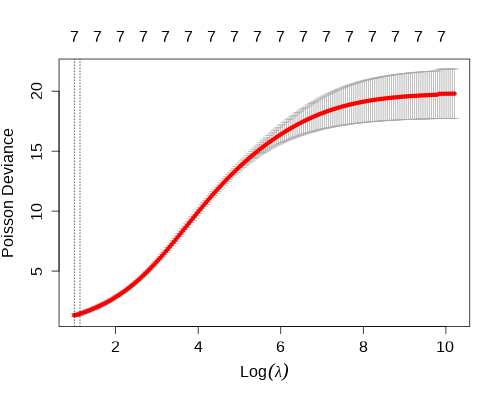

In [ ]:
%%R -w 500 -h 400 -u px
plot(ridge.cv)

The plot shows the cross-validation error based on the logarithm of lambda. The dashed vertical line on the left indicates that the optimal logarithm of lambda is around -2, which minimizes the prediction error. This lambda value will provide the most accurate model. The exact value of lambda can be viewed as follow:

In [ ]:
%%R
ridge.cv$lambda.min

[1] 2.715607


Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lambda.1se`.


#### Fit ridge regression

Now Fit the final model with the best "lambda":


In [ ]:
%%R
# fit ridge regression
ridge.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=0,
                       lambda = ridge.cv$lambda.1se,
                       ffset = m_offset,
                       family = "poisson",
                       nlambda=200,  standardize = TRUE)

In [ ]:
%%R
# Display regression coefficients
coef(ridge.fit, s=1 )

8 x 1 sparse Matrix of class "dgCMatrix"
                               s1
(Intercept)          1.429487e+00
POP_Total           -1.546541e-10
Obesity              1.121033e-02
Physical_Inactivity  1.479587e-02
Access_Excercise    -5.632992e-04
Food_Env_Index      -2.155336e-02
SVI                  1.221946e-01
log_POP_Total        1.578883e-02


#### Prediction at test data

The `predict()` function will be used to predict the number of diabetes patients the test counties. This will help to validate the accuracy of the these regression model.

In [ ]:
%%R
df.test<-train[,-8]
# Make predictions on the test data
x.test <- model.matrix(Diabetes_per ~., df.train)[,-1]
# Outcome variable
y.test <-df.test$Diabetes_per

ridge.Diabetes<-ridge.fit  |>
  predict(x.test, type="response")  |>  as.vector()
ridge.pred<-as.data.frame(cbind("Obs_Diabetes" = y.test, "Pred_Diabetes "=ridge.Diabetes))
ridge.pred$Obs_Diabetes<-as.numeric(ridge.pred$Obs_Diabetes)
ridge.pred$Pred_Diabetes<-as.numeric(ridge.pred$Pred_Diabetes)
glimpse(ridge.pred)

Rows: 2,173
Columns: 3
$ Obs_Diabetes     <dbl> 8, 6, 8, 12, 9, 7, 7, 6, 8, 7, 8, 7, 8, 6, 8, 6, 7, 1…
$ `Pred_Diabetes ` <dbl> 7.042856, 6.080356, 7.513611, 10.893532, 8.333742, 6.…
$ Pred_Diabetes    <dbl> 7.042856, 6.080356, 7.513611, 10.893532, 8.333742, 6.…


#### Model performance metrics

In [ ]:
%%R
calculate_metrics <- function(observed, predicted) {
  # Ensure inputs are numeric vectors
  observed <- as.numeric(observed)
  predicted <- as.numeric(predicted)

  # Compute metrics
  mse <- mean((observed - predicted)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(observed - predicted))
  medae <- median(abs(observed - predicted))
  r2 <- 1 - sum((observed - predicted)^2) / sum((observed - mean(observed))^2)

  # Return results as a named list
  metrics <- list(
    RMSE = rmse,
    MAE = mae,
    MSE = mse,
    MedAE = medae,
    R2 = r2
  )
  return(metrics)
}

In [ ]:
%%R
calculate_metrics(ridge.pred$Obs_Diabetes, ridge.pred$Pred_Diabetes)

$RMSE
[1] 0.870645

$MAE
[1] 0.680785

$MSE
[1] 0.7580227

$MedAE
[1] 0.5511891

$R2
[1] 0.7097025



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


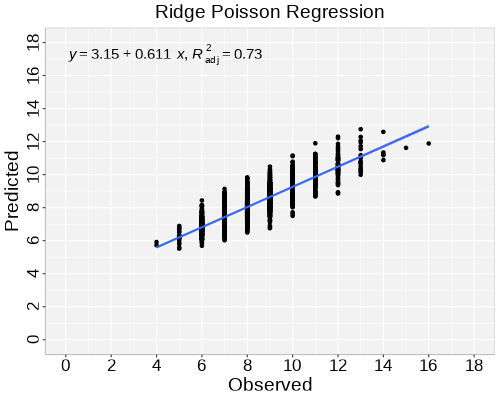

In [ ]:
%%R -h 400 -w 500 -u px
formula<-y~x
# Lasso regression
p1=ggplot(ridge.pred, aes(Obs_Diabetes, Pred_Diabetes)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Ridge Poisson Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,18), breaks=seq(0, 18, 2))+
  scale_y_continuous(limits=c(0,18), breaks=seq(0, 18, 2)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p1)

### Lasso Regression


#### Cross-validation for the best lambda

Now we can apply `cv.glmnet()` function for cross-validation to choose the best lambda (regularization parameter). For example, suppose we designate $α$=1 for lasso regression and specify `nlambda` as 200. This implies that the model fit will be calculated solely for 200 $λ$ values.

We specify `family = poisson"` to indicate that we want to fit a Poisson regression model. Here we model the diabetes rate per county, The `offset` variable, here is log population per county need to be defined in model. This offset variable adjusts for the differing number of diabetes patients in different population levels per county.

In [ ]:
%%R
# cross validation
lasso.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="deviance",
                       nfold = 5,
                       alpha=1,
                       offset = m_offset,
                       family = "poisson",
                       nlambda=200, standardize = TRUE)

Printing the resulting object gives some basic information on the cross-validation performed:

In [ ]:
%%R
print(lasso.cv)


Call:  cv.glmnet(x = x.train, y = y.train, offset = m_offset, type.measure = "deviance",      nfolds = 5, alpha = 1, family = "poisson", nlambda = 200,      standardize = TRUE) 

Measure: Poisson Deviance 

     Lambda Index Measure       SE Nonzero
min 0.08738   125 0.08975 0.004334       7
1se 0.12081   118 0.09365 0.004859       7


We can plot `lasso.cv` object to see how each tested lambda value performed:

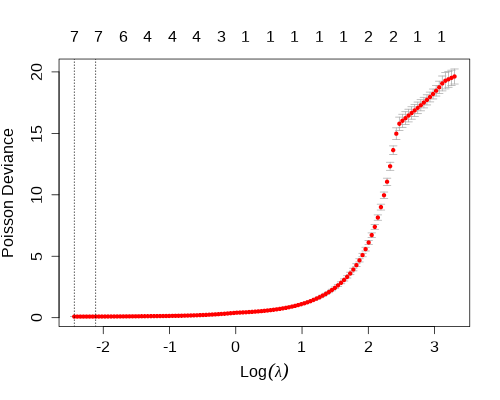

In [ ]:
%%R -h 400 -w 500 -u px
plot(lasso.cv)

In [ ]:
%%R
lasso.cv$lambda.min

[1] 0.0873785


Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lasso.1se`.

#### Fit lasso regression

Now Fit the final model with the best "lambda":

In [ ]:
%%R
# fit ridge regression
lasso.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=1,
                       lambda = lasso.cv$lambda.1se,
                       ffset = m_offset,
                       family = "poisson",
                       nlambda=200,
                       standardize = TRUE)


In [ ]:
%%R
# Display regression coefficients
coef(lasso.fit, s=1 )

8 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)          1.357472719
POP_Total            .          
Obesity              0.010708288
Physical_Inactivity  0.018882369
Access_Excercise     .          
Food_Env_Index      -0.007848856
SVI                  0.143520688
log_POP_Total        0.001482070


#### Prediction at test data

The `predict()` function will be used to predict the number of diabetes patients the test counties. This will help to validate the accuracy of the these regression model.

In [ ]:
%%R
df.test<-train[,-8]
# Make predictions on the test data
x.test <- model.matrix(Diabetes_per ~., df.train)[,-1]
# Outcome variable
y.test <-df.test$Diabetes_per

lasso.Diabetes<-lasso.fit  |>
  predict(x.test, type="response")  |>  as.vector()

lasso.pred<-as.data.frame(cbind("Obs_Diabetes" = y.test, "Pred_Diabetes "=lasso.Diabetes))
lasso.pred$Obs_Diabetes<-as.numeric(lasso.pred$Obs_Diabetes)
lasso.pred$Pred_Diabetes<-as.numeric(lasso.pred$Pred_Diabetes)
glimpse(ridge.pred)

Rows: 2,173
Columns: 3
$ Obs_Diabetes     <dbl> 8, 6, 8, 12, 9, 7, 7, 6, 8, 7, 8, 7, 8, 6, 8, 6, 7, 1…
$ `Pred_Diabetes ` <dbl> 7.042856, 6.080356, 7.513611, 10.893532, 8.333742, 6.…
$ Pred_Diabetes    <dbl> 7.042856, 6.080356, 7.513611, 10.893532, 8.333742, 6.…


In [ ]:
%%R
# Model performance metrics
calculate_metrics(lasso.pred$Obs_Diabetes, lasso.pred$Pred_Diabetes)

$RMSE
[1] 0.8801197

$MAE
[1] 0.687431

$MSE
[1] 0.7746107

$MedAE
[1] 0.5542317

$R2
[1] 0.7033498




#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


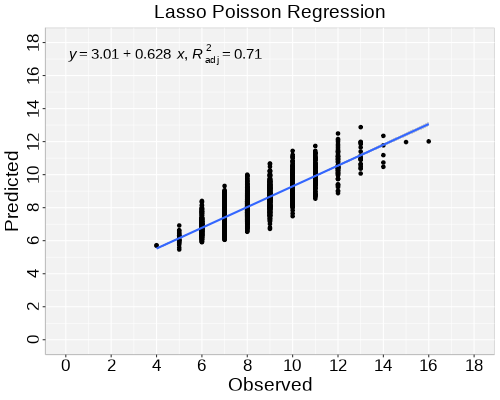

In [ ]:
%%R -w 500 -h 400 -u px
formula<-y~x
# Lasso regression
p2=ggplot(lasso.pred, aes(Obs_Diabetes, Pred_Diabetes)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Lasso Poisson Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,18), breaks=seq(0, 18, 2))+
  scale_y_continuous(limits=c(0,18), breaks=seq(0, 18, 2)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p2)

### Elastic Net Regression

Elastic Net regression is a combination of L1 (LASSO) and L2 (Ridge) regularization. It provides a balance between feature selection and coefficient shrinkage. The {glmnet} package in R provides efficient functions for fitting Elastic Net regression models.

#### Cross Validation of the best Elastic Net regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha`argument to a value between 0 and 1 and do K-fold cross-validation:

In [ ]:
%%R
# Define alpha values for Lasso, Ridge, and Elastic Net
alpha_values <- seq(0, 1, by = 0.1)

# Lambda will be generated automatically, but you can also define it manually:
lambda_values <- 10^seq(-4, 1, length.out = 100) # Logarithmic scale

# Cross-validation
results <- list()
for (alpha in alpha_values) {
  cv_model <- cv.glmnet(
    x = x.train,
    y = y.train,
    alpha = alpha,
    lambda = lambda_values,
    nfolds = 5, # 5-fold cross-validation
    standardize = TRUE, # Standardizes the predictors by default
    offset = m_offset,
    family = "poisson"
  )

  # Store results
  results[[paste("alpha=", alpha)]] <- list(
    alpha = alpha,
    best_lambda = cv_model$lambda.min,
    cv_model = cv_model
  )
}

best_result <- NULL
min_mse <- Inf

for (res in results) {
  mse <- min(res$cv_model$cvm) # Mean squared error
  if (mse < min_mse) {
    min_mse <- mse
    best_result <- res
  }
}

# Best model
cat("Best alpha:", best_result$alpha, "\n")
cat("Best lambda:", best_result$best_lambda, "\n")

Best alpha: 0.6 
Best lambda: 1e-04 


#### Fit Elastic Net regression

In [ ]:
%%R
enet.fit  <- glmnet(
  x = x.train,
  y = y.train,
  alpha = best_result$alpha,
  lambda = best_result$best_lambda,
  standardize = TRUE,
  family = "poisson",
)

#### Prediction at Test Data

Now, we will test this model on our test dataset by calculating the model-predicted values for the test dataset

In [ ]:
%%R
df.test<-train[,-8]
# Make predictions on the test data
x.test <- model.matrix(Diabetes_per ~., df.train)[,-1]
# Outcome variable
y.test <-df.test$Diabetes_per

enet.Diabetes<-enet.fit   |>
  predict(x.test,  type="response")  |>  as.vector()

enet.pred<-as.data.frame(cbind("Obs_Diabetes" = y.test, "Pred_Diabetes "=enet.Diabetes))
enet.pred$Obs_Diabetes<-as.numeric(enet.pred$Obs_Diabetes)
enet.pred$Pred_Diabetes<-as.numeric(enet.pred$Pred_Diabetes)
glimpse(enet.pred)

Rows: 2,173
Columns: 3
$ Obs_Diabetes     <dbl> 8, 6, 8, 12, 9, 7, 7, 6, 8, 7, 8, 7, 8, 6, 8, 6, 7, 1…
$ `Pred_Diabetes ` <dbl> 6.782780, 5.763534, 7.354667, 11.531311, 8.274558, 6.…
$ Pred_Diabetes    <dbl> 6.782780, 5.763534, 7.354667, 11.531311, 8.274558, 6.…


In [ ]:
%%R
calculate_metrics(enet.pred$Obs_Diabetes, enet.pred$Pred_Diabetes)

$RMSE
[1] 0.8381801

$MAE
[1] 0.6603934

$MSE
[1] 0.7025458

$MedAE
[1] 0.5479883

$R2
[1] 0.7309483



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


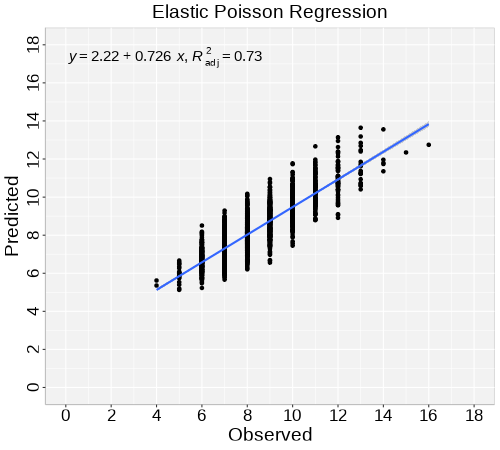

In [ ]:
%%R -w 500 -h 450 -u px
formula<-y~x
# Esatic Net regression
p3=ggplot(enet.pred, aes(Obs_Diabetes, Pred_Diabetes)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Elastic Poisson Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,18), breaks=seq(0, 18, 2))+
  scale_y_continuous(limits=c(0,18), breaks=seq(0, 18, 2)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p3)


## Summary and Conclusion

In this tutorial, we explored the concept of Regularized Poisson Regression and its application for modeling count data in R. The main objectives were to understand the theoretical foundations of regularization and implement it using a manual approach and the {glmnet} package. By mastering the theoretical and practical aspects of regularized Poisson regression, you will be well-equipped to apply these techniques effectively across various contexts, from research to industry. Whether you are focused on predictive modeling, feature selection, or addressing overfitting, regularization offers robust solutions for analyzing count data.

## References

1.  [Poisson frequency models in glmnet](https://actuary.rbind.io/post/glmnet-frequency/)
